# ДЗ

Задание на кластеризацию, понижение размерности и классификацию.

Мы будем работать с набором данных [Samsung Human Activity Recognition](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones). Скачайте данные [отсюда](https://drive.google.com/file/d/14RukQ0ylM2GCdViUHBBjZ2imCaYcjlux/view?usp=sharing). Данные поступают с акселерометров и гироскопов мобильных телефонов Samsung Galaxy S3 (подробнее про признаки – по ссылке на UCI выше), также известен вид активности человека с телефоном в кармане – ходил ли он, стоял, лежал, сидел или шел вверх/вниз по лестнице.

Вначале мы представим, что вид активности нам неизвестнен, и попробуем кластеризовать людей чисто на основе имеющихся признаков. Затем решим задачу определения вида физической активности именно как задачу классификации.

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook
from matplotlib.colors import ListedColormap

%matplotlib inline


plt.style.use(['seaborn-darkgrid'])
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'

from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering, KMeans, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.metrics.cluster import adjusted_rand_score

import gc

sns.set()
%matplotlib inline

import sys
# np.set_printoptions(suppress=True)
# np.set_printoptions(threshold=sys.maxsize)
# np.set_printoptions(precision=3)

DISPLAY_MAX_ROWS = 20 #20
pd.set_option('display.max_rows', DISPLAY_MAX_ROWS)
pd.set_option('display.max_column', 100) # None)
plt.style.use('seaborn-whitegrid')


# plt.rcParams["figure.figsize"] = (20, 15)

import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 17

<ipython-input-3-035516a233cc>:11: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use(['seaborn-darkgrid'])
<ipython-input-3-035516a233cc>:35: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


In [ ]:
X_train = np.loadtxt("samsung_train.txt")
y_train = np.loadtxt("samsung_train_labels.txt").astype(int)

X_test = np.loadtxt("samsung_test.txt")
y_test = np.loadtxt("samsung_test_labels.txt").astype(int)

In [ ]:
# Проверим размерности
assert(X_train.shape == (7352, 561) and y_train.shape == (7352,))
assert(X_test.shape == (2947, 561) and y_test.shape == (2947,))

Для кластеризации нам не нужен вектор ответов, поэтому будем работать с объединением обучающей и тестовой выборок. Объедините *X_train* с *X_test*, а *y_train* – с *y_test*.

In [ ]:
X = np.concatenate([X_train, X_test])
y = np.concatenate([y_train, y_test])

Определим число уникальных значений меток целевого класса.

In [ ]:
np.unique(y)

array([1, 2, 3, 4, 5, 6])

In [ ]:
n_classes = np.unique(y).size

[Эти метки соответствуют:](https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.names)
- 1 - ходьбa
- 2 - подъем вверх по лестнице
- 3 - спуск по лестнице
- 4 - сидит
- 5 - стоит
- 6 - лежит



Отмасштабируйте выборку с помощью `StandardScaler` с параметрами по умолчанию.

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled, X

(array([[ 2.10533854e-01, -6.87026385e-02, -4.52194533e-01, ...,
         -6.74432366e-01,  3.82007658e-01, -1.61505480e-02],
        [ 6.02084832e-02,  3.59023537e-02, -2.75221885e-01, ...,
         -6.81359801e-01,  3.83147865e-01, -1.20627169e-04],
        [ 7.84597052e-02, -4.64269585e-02, -8.55480582e-02, ...,
         -6.89470939e-01,  3.84288531e-01,  1.92144041e-02],
        ...,
        [ 1.11821625e+00,  1.28805864e+00, -1.29414692e-01, ...,
         -3.10750224e-01,  6.91509049e-01,  8.75719123e-01],
        [-5.43492722e-01,  9.75327452e-01,  2.34319837e-01, ...,
         -3.19283719e-01,  6.59762215e-01,  8.99444350e-01],
        [-1.78515253e+00, -1.86663622e-02, -5.29759691e-01, ...,
         -3.19991245e-01,  6.56994458e-01,  9.01454465e-01]]),
 array([[ 0.28858451, -0.02029417, -0.13290514, ..., -0.84124676,
          0.17994061, -0.05862692],
        [ 0.27841883, -0.01641057, -0.12352019, ..., -0.8447876 ,
          0.18028889, -0.05431672],
        [ 0.27965306, -0.

Понижаем размерность с помощью PCA, оставляя столько компонент, сколько нужно для того, чтобы объяснить как минимум 90% дисперсии исходных (отмасштабированных) данных. Используйте отмасштабированную выборку и зафиксируйте random_state (константа RANDOM_STATE).

In [ ]:
pca = PCA(0.9, random_state=RANDOM_STATE)
X_pca = pca.fit(X_scaled)

**Вопрос 1:**<br>
Какое минимальное число главных компонент нужно выделить, чтобы объяснить 90% дисперсии исходных (отмасштабированных) данных?

In [ ]:
pca.n_components_

65

**Варианты:**
- 56
- **65**
- 66
- 193

**Ответ:** 65

**Вопрос 2:**<br>
Сколько процентов дисперсии приходится на первую главную компоненту? Округлите до целых процентов.

**Варианты:**
- 45
- 51
- 56
- 61

In [ ]:
round(pca.explained_variance_ratio_[0] * 100)

51

**Ответ:** 51

Визуализируйте данные в проекции на первые две главные компоненты.

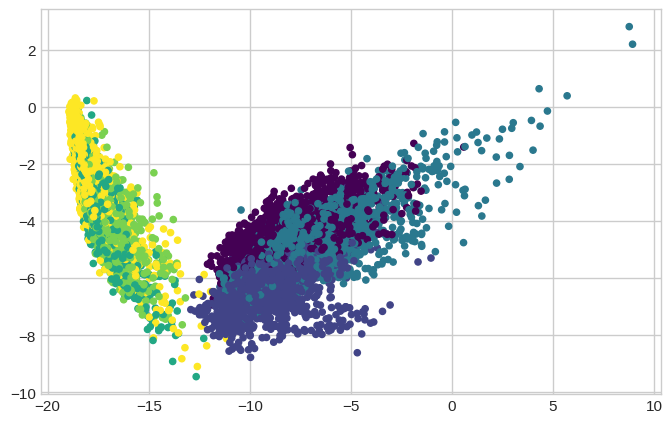

In [ ]:
plt.figure(figsize=(8,5))
X_pca = pca.transform(X)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, s=20, cmap='viridis')
plt.show()

**Вопрос 3:**<br>
Если все получилось правильно, Вы увидите сколько-то кластеров, почти идеально отделенных друг от друга. Какие виды активности входят в эти кластеры?<br>

**Ответ:**
- 1 кластер: все 6 активностей
- **2 кластера: (ходьба, подъем вверх по лестнице, спуск по лестнице) и (сидение, стояние, лежание)**
- 3 кластера: (ходьба), (подъем вверх по лестнице, спуск по лестнице) и (сидение, стояние, лежание)
- 6 кластеров

**Ответ:** 2 кластера: (ходьба, подъем вверх по лестнице, спуск по лестнице) и (сидение, стояние, лежание)

------------------------------

Сделайте кластеризацию данных методом `KMeans`, обучив модель на данных со сниженной за счет PCA размерностью. В данном случае мы подскажем, что нужно искать именно 6 кластеров, но в общем случае мы не будем знать, сколько кластеров надо искать.

Параметры:

- **n_clusters** = n_classes (число уникальных меток целевого класса)
- **n_init** = 100
- **random_state** = RANDOM_STATE (для воспроизводимости результата)

Остальные параметры со значениями по умолчанию.

In [ ]:
kmeans = KMeans(n_clusters = n_classes, n_init = 100, init = 'k-means++', random_state = RANDOM_STATE)
y_kmeans = kmeans.fit_predict(X_pca)

In [ ]:
y_kmeans

array([4, 4, 4, ..., 3, 3, 3], dtype=int32)

Визуализируйте данные в проекции на первые две главные компоненты. Раскрасьте точки в соответствии с полученными метками кластеров.

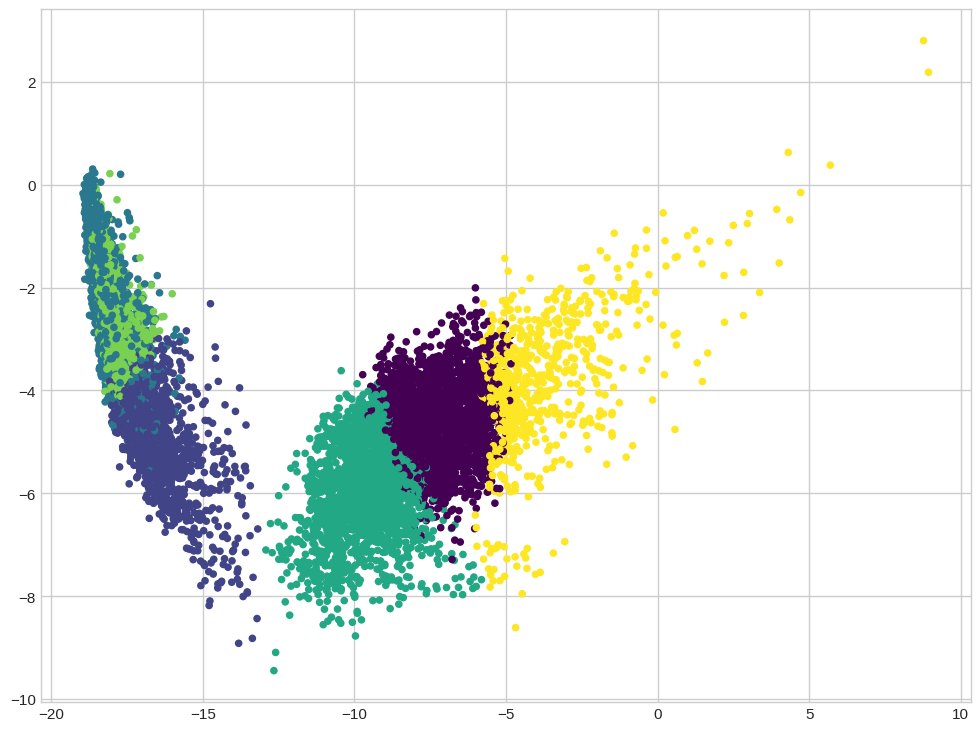

In [ ]:
cluster_labels = kmeans.labels_
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, s=20,  cmap='viridis');

Посмотрите на соответствие между метками кластеров и исходными метками классов и на то, какие виды активностей алгоритм `KMeans` путает.

In [ ]:
tab = pd.crosstab(y, cluster_labels, margins=True)
tab.index = ['ходьба', 'подъем вверх по лестнице',
             'спуск по лестнице', 'сидение', 'стояние', 'лежание', 'все']
tab.columns = ['cluster' + str(i + 1) for i in range(6)] + ['все']
tab

,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,все
ходьба,876,0,0,693,0,153,1722
подъем вверх по лестнице,293,0,0,1170,0,81,1544
спуск по лестнице,758,0,0,188,0,460,1406
сидение,0,479,51,3,1244,0,1777
стояние,0,670,0,0,1236,0,1906
лежание,0,191,1739,12,2,0,1944
все,1927,1340,1790,2066,2482,694,10299


Видим, что каждому классу (т.е. каждой активности) соответствуют несколько кластеров. Давайте посмотрим на максимальную долю объектов в классе, отнесенных к какому-то одному кластеру. Это будет простой метрикой, характеризующей, насколько легко класс отделяется от других при кластеризации.

Пример: если для класса "спуск по лестнице", в котором 1406 объектов,  распределение кластеров такое:
 - кластер 1 – 900
 - кластер 3 – 500
 - кластер 6 – 6,

то такая доля будет 900 / 1406 $\approx$ 0.64.


**Вопрос 4:**<br>
Какой вид активности отделился от остальных лучше всего в терминах простой  метрики, описанной выше?<br>

**Ответ:**
- ходьба
- стояние
- спуск по лестнице
- **перечисленные варианты не подходят**

**Ответ:** Перечисленные варианты не подходят

Видно, что kMeans не очень хорошо отличает только активности друг от друга. Используйте метод локтя, чтобы выбрать оптимальное количество кластеров. Параметры алгоритма и данные используем те же, что раньше, меняем только `n_clusters`.

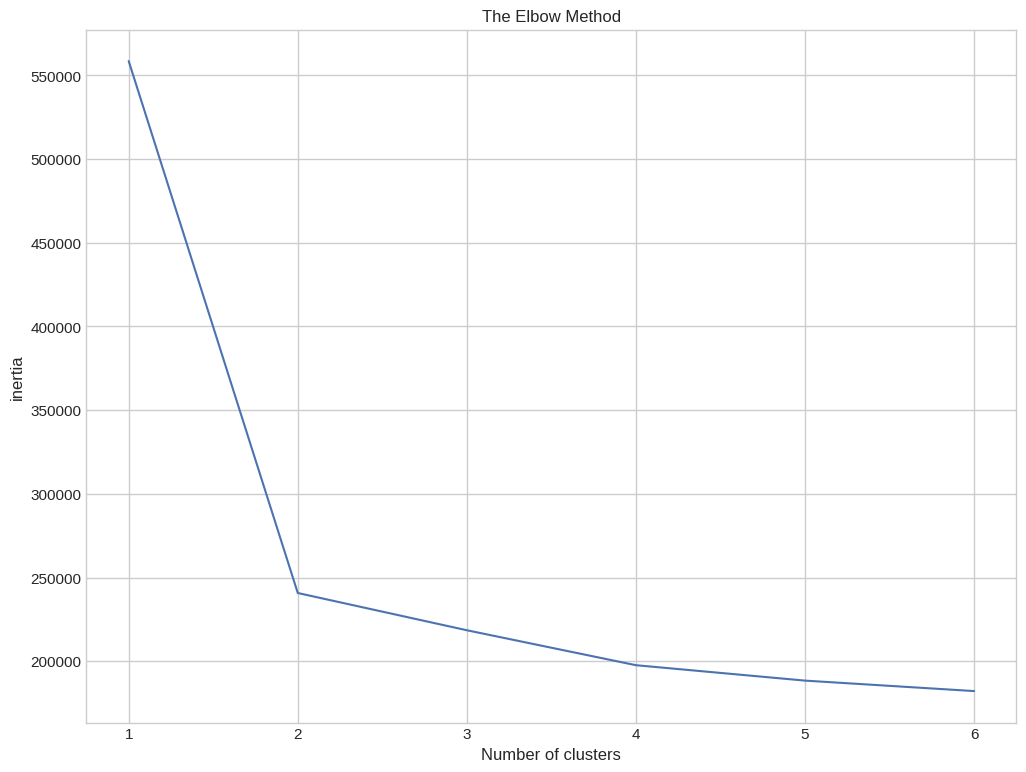

In [ ]:
inertia = []
for i in range(1, n_classes +1):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)
plt.plot(range(1, 7), inertia)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('inertia')
plt.show()

**Вопрос 5:**<br>
Какое количество кластеров оптимально выбрать, согласно методу локтя?<br>

**Ответ:**
- 1
- **2**
- 3
- 4

**Ответ:** 2

------------------------

Попробуем еще один метод кластеризации, который описывался в статье – агломеративную кластеризацию.

In [ ]:
ag = AgglomerativeClustering(n_clusters=n_classes,
                             linkage='ward').fit(X_pca)

Посчитайте Adjusted Rand Index (`sklearn.metrics`) для получившегося разбиения на кластеры и для `KMeans` с параметрами из задания к 4 вопросу.

In [ ]:
print(adjusted_rand_score(y, ag.labels_))
print(adjusted_rand_score(y, kmeans.labels_))

0.5000085833267824
0.4611114181109749


**Вопрос 6:**<br>
Отметьте все верные утверждения.<br>

**Варианты:**
- **Согласно ARI, KMeans справился с кластеризацией хуже, чем Agglomerative Clustering**
- **Для ARI не имеет значения какие именно метки присвоены кластерам, имеет значение только разбиение объектов на кластеры**
- **В случае случайного разбиения на кластеры ARI будет близок к нулю**

-------------------------------

**Ответ:** Все утверждения верны

Можно заметить, что задача не очень хорошо решается именно как задача кластеризации, если выделять несколько кластеров (> 2). Давайте теперь решим задачу классификации, вспомнив, что данные у нас размечены.  

Для классификации используйте метод опорных векторов – класс `sklearn.svm.LinearSVC`. Мы в курсе отдельно не рассматривали этот алгоритм, но он очень известен, почитать про него можно, например, в материалах Евгения Соколова –  [тут](https://github.com/esokolov/ml-course-msu/blob/master/ML16/lecture-notes/Sem11_linear.pdf).

Настройте для `LinearSVC` гиперпараметр `C` с помощью `GridSearchCV`.

- Обучите новый `StandardScaler` на обучающей выборке (со всеми исходными признаками), прмиените масштабирование к тестовой выборке
- В `GridSearchCV` укажите  cv=3.

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
svc = LinearSVC(random_state=RANDOM_STATE)
svc_params = {'C': [0.001, 0.01, 0.1, 1, 10]}

In [ ]:
model = GridSearchCV(svc, cv=3, param_grid=svc_params).fit(X_train_scaled, y_train)
best_svc = model.best_estimator_

In [ ]:
model.best_params_

{'C': 0.1}

In [ ]:
model.best_score_

0.9382506099134881

**Вопрос 7**<br>
Какое значение гиперпараметра `C` было выбрано лучшим по итогам кросс-валидации?<br>

**Ответ:**
- 0.001
- 0.01
- **0.1**
- 1
- 10

**Ответ:** 0.1

In [ ]:
y_predicted = best_svc.predict(X_test_scaled)

In [ ]:
tab = pd.crosstab(y_test, y_predicted, margins=True)
tab.index = ['ходьба', 'подъем вверх по лестнице', 'спуск по лестнице',
             'сидение', 'стояние', 'лежание', 'все']
tab.columns = tab.index
tab

,ходьба,подъем вверх по лестнице,спуск по лестнице,сидение,стояние,лежание,все
ходьба,494,2,0,0,0,0,496
подъем вверх по лестнице,12,459,0,0,0,0,471
спуск по лестнице,2,3,414,1,0,0,420
сидение,0,4,0,426,61,0,491
стояние,0,0,0,15,517,0,532
лежание,0,0,0,0,11,526,537
все,508,468,414,442,589,526,2947


**Вопрос 8:**<br>
Какой вид активности SVM определяет хуже всего в терминах точности? Полноты? <br>

**Ответ:**
- по точности – подъем вверх по лестнице, по полноте – лежание
- по точности – лежание, по полноте – сидение
- по точности – ходьба, по полноте – ходьба
- по точности – сидение, по полноте – стояние

In [ ]:
print(metrics.classification_report(y_test, y_predicted, target_names=tab.index[:6]))

                          precision    recall  f1-score   support

                  ходьба       0.97      1.00      0.98       496
подъем вверх по лестнице       0.98      0.97      0.98       471
       спуск по лестнице       1.00      0.99      0.99       420
                 сидение       0.96      0.87      0.91       491
                 стояние       0.88      0.97      0.92       532
                 лежание       1.00      0.98      0.99       537

                accuracy                           0.96      2947
               macro avg       0.97      0.96      0.96      2947
            weighted avg       0.96      0.96      0.96      2947



**Ответ:** хуже всего SVM определяет по точности стояние, по полноте - сидение

Наконец, проделайте то же самое, что в 7 вопросе, только добавив PCA.

- Используйте выборки `X_train_scaled` и `X_test_scaled`
- Обучите тот же PCA, что раньше, на отмасшабированной обучающей выборке, примените преобразование к тестовой
- Настройте гиперпараметр `C` на кросс-валидации по обучающей выборке с PCA-преобразованием. Вы заметите, насколько это проходит быстрее, чем раньше.

**Вопрос 9:**<br>
Какова разность между лучшим качеством (долей верных ответов) на кросс-валидации в случае всех 561 исходных признаков и во втором случае, когда применялся метод главных компонент? Округлите до целых процентов.<br>

**Варианты:**
- **Качество одинаковое**
- 2%
- 4%
- 10%
- 20%


In [ ]:
pca = PCA().fit(X_train_scaled)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [ ]:
svc = LinearSVC(random_state=RANDOM_STATE)
svc_params = {'C': [0.001, 0.01, 0.1, 1, 10]}

In [ ]:
model = GridSearchCV(svc, cv=3, param_grid=svc_params).fit(X_train_pca, y_train)
best_svc = model.best_estimator_

In [ ]:
model.best_params_

{'C': 0.1}

In [ ]:
model.best_score_

0.9382506099134881

**Ответ:** Качество одинаковое

**Вопрос 10:**<br>
Выберите все верные утверждения:

**Варианты:**
- Метод главных компонент в данном случае позволил уменьшить время обучения модели, при этом качество (доля верных ответов на кросс-валидации) очень пострадало, более чем на 10%
- **PCA можно использовать для визуализации данных, однако для этой задачи есть и лучше подходящие методы, например, tSNE. Зато PCA имеет меньшую вычислительную сложность**
- **PCA строит линейные комбинации исходных признаков, и в некоторых задачах они могут плохо интерпретироваться человеком**

**Ответ:** Верны утверждения 2, 3